In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch

%matplotlib inline

In [3]:
from torch.nn.functional import cross_entropy

def sample_data(count=10000):
    rand = np.random.RandomState(0)
    a = 0.3 + 0.1 * rand.randn(count)
    b = 0.8 + 0.05 * rand.randn(count)
    mask = rand.rand(count) < 0.5
    samples = np.clip(a * mask + b * (1 - mask), 0.0, 1.0)
    return np.digitize(samples, np.linspace(0.0, 1.0, 100))

def model_loglik(x, theta):
    return cross_entropy(theta.repeat(x.shape[0], 1), x)

def softmax(theta):
    stable_theta = theta - theta.max()
    return np.exp(stable_theta) / np.exp(stable_theta).sum()

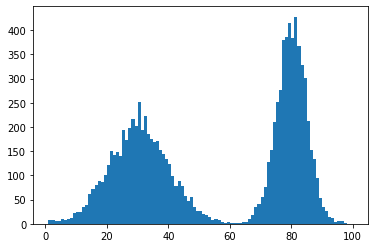

In [4]:
data = sample_data()
plt.hist(data, bins=np.arange(1, 101))

n_train = int(.8 * len(data))
n_test = len(data) - n_train

x_test = torch.tensor(data[n_train:])
x_val = torch.tensor(sample_data(2000))

In [5]:
from torch.utils.data import DataLoader

device = torch.device("cpu")
# device = torch.device("cuda:0") # Uncomment this to run on GPU
learning_rate = 1e-1

batch_size = 100
n_epochs = 100

# initialize parameters
theta = torch.zeros(100, device=device, requires_grad=True)
train_loader = DataLoader(torch.tensor(data[:n_train]), batch_size=batch_size)

train_logliks = []
valid_logliks = []
valid_t = []
# training loop
for t in range(n_epochs):
    valid_logliks.append(model_loglik(x_val, theta) / np.log(2))
    valid_t.append(t*len(train_loader))
    for i, x in enumerate(train_loader):
        # compute likelihood
        loss = model_loglik(x, theta)

        # record likelihood in units of bits
        train_logliks.append(loss / np.log(2))
        
        loss.backward()
        with torch.no_grad():
            theta -= learning_rate * theta.grad
            theta.grad.zero_()

Visualize the time course of the likelihood of training and validation set:

tensor(4.0394)


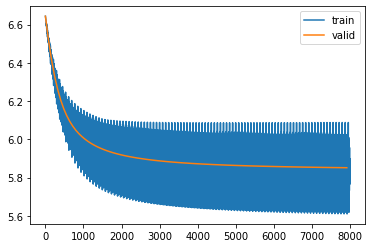

In [6]:
plt.figure()
plt.plot(train_logliks, label='train')
plt.plot(valid_t, valid_logliks, label='valid')
test_loglik = model_loglik(x_test, theta)
# plt.hlines(, 0, len(train_logliks), label='test')
# Test performance:
print(test_loglik.data)
plt.legend()

What to expect? Uniform distribution would have likelihood of $p(x) = 1 / 100$. Minimum reachable log-likelihood??

In [25]:
- np.log2(1/100)
pdf, edges = np.histogram(data, bins=np.arange(.5, 100.5))
print(type(pdf))
pdf = pdf / len(data)
pdf[pdf == 0] = 1
# plt.bar(edges[:-1], pdf, width=1)
np.mean(-np.log2(pdf[data[:n_train]]))

<class 'numpy.ndarray'>


5.855591415151522

0.058950104


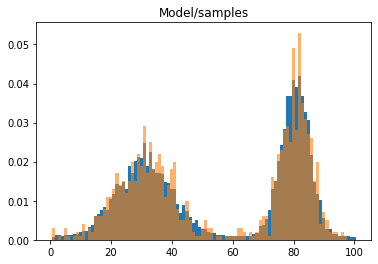

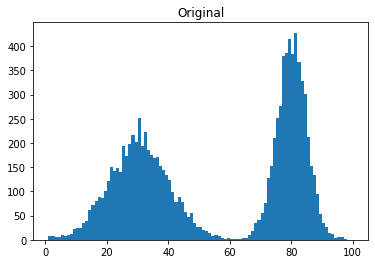

In [23]:
# make positive
theta.requires_grad = False
pdf = softmax(theta)
plt.figure()
_ = plt.title('Model/samples')
plt.bar(np.arange(1, 101), pdf, width=1)

# draw some samples
cdf = np.cumsum(pdf) / pdf.sum()
n_samples = 1000
samples = []
for i in range(n_samples):
    samples.append(np.nonzero(np.random.rand() < cdf)[0][0])
h, edges = np.histogram(samples, bins=np.arange(101))
plt.bar(edges[:-1] + 1, h / h.sum(), width=1, alpha=.6)
plt.figure()
plt.hist(data, bins=np.arange(1, 101))
_ = plt.title('Original')